In [171]:
import os
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
minute_interval = 15
non_reoccuring_number = 100

In [8]:
features = pd.read_csv(f"../../data/features_corrected_2_{minute_interval}_{non_reoccuring_number}.csv")
peaks = pd.read_csv(f"../../data/peaks.csv") 
sea = pd.read_csv(f"../../data/seasonal.csv")

In [16]:
sea['label'] = ["sea" for x in range(0, len(sea))]
peaks['label'] = ["peak" for x in range(0, len(peaks))]

In [56]:
lfeatures = pd.merge(features, sea, on='hash')
lfeatures = lfeatures.append(pd.merge(features, peaks, on='hash'))
lfeatures = lfeatures.drop(columns=['lf_rsn_a12','lf_rsn_c12','lf_rsn_w12','all_s_w12','lf_rsn_a12_label','lf_rsn_c12_label','lf_rsn_w12_label','all_s_w12_label'])
lfeatures = lfeatures.fillna(0)

In [88]:
classification_features = ['mean', 'std', 'skew','l1', 'l2', 'l3', 'c95', 'above-c95', 'aic', 'bic', 'ar_intercept','ar_0', 'ar_2', 'ar_4', 'ar_8', 'ar_12', 'ar_24', 'ar_47', 'diff-mean','diff-std', 'diff-skew']

In [89]:
f_train, f_test, l_train, l_test = train_test_split(lfeatures[classification_features], lfeatures['label'], test_size=0.25, random_state=1, stratify=lfeatures['label'])
f_train, f_val, l_train, l_val = train_test_split(f_train, l_train, test_size=0.25, random_state=1, stratify=l_train)

In [90]:
l_train.value_counts()

peak    7230
sea      101
Name: label, dtype: int64

In [91]:
l_test.value_counts()

peak    3214
sea       45
Name: label, dtype: int64

In [92]:
l_val.value_counts()

peak    2410
sea       34
Name: label, dtype: int64

In [93]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(f_train,l_train)

RandomForestClassifier()

In [146]:
l_predictions = clf.predict(f_test)
print(f"Test accuracy: {metrics.accuracy_score(l_test, l_predictions)}")
print(classification_report(l_test, l_predictions))

Test accuracy: 0.9935563056152193
              precision    recall  f1-score   support

        peak       0.99      1.00      1.00      3214
         sea       0.88      0.62      0.73        45

    accuracy                           0.99      3259
   macro avg       0.93      0.81      0.86      3259
weighted avg       0.99      0.99      0.99      3259



In [145]:
l_predictions = clf.predict(f_val)
print(f"Validation accuracy: {metrics.accuracy_score(l_val, l_predictions)}")
print(classification_report(l_val, l_predictions))

Validation accuracy: 0.9909983633387889
              precision    recall  f1-score   support

        peak       0.99      1.00      1.00      2410
         sea       0.75      0.53      0.62        34

    accuracy                           0.99      2444
   macro avg       0.87      0.76      0.81      2444
weighted avg       0.99      0.99      0.99      2444



In [124]:
useful_features = pd.DataFrame(clf.feature_importances_, index=classification_features)
useful_features.columns=['usefulness']

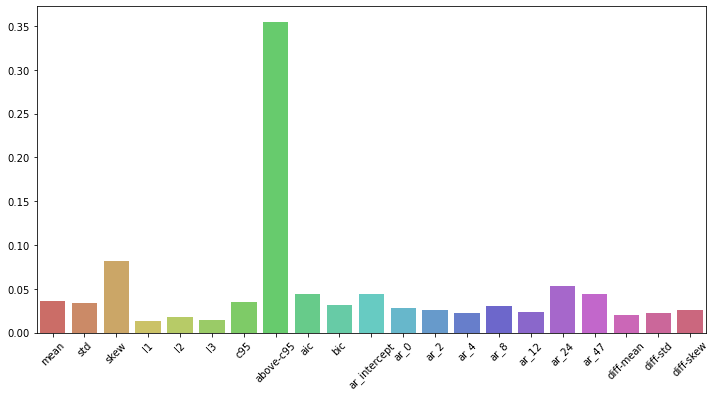

In [163]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
g = sns.barplot(x=useful_features.index, y=useful_features['usefulness'].values, ax=ax, palette=sns.color_palette("hls", len(classification_features)))
labels = [item.get_text() for item in g.get_xticklabels()]
g.set_xticklabels(labels, rotation=45)
plt.show()

In [165]:
useful_features.nlargest(6, columns=['usefulness'])

array(['above-c95', 'skew', 'ar_24', 'ar_intercept', 'ar_47', 'aic'],
      dtype=object)

In [187]:
reduced_features = useful_features.nlargest(6, columns=['usefulness']).index.values
f_train, f_test, l_train, l_test = train_test_split(lfeatures[['above-c95','skew', 'ar_intercept']], lfeatures['label'], test_size=0.25, random_state=1, stratify=lfeatures['label'])
f_train, f_val, l_train, l_val = train_test_split(f_train, l_train, test_size=0.25, random_state=1, stratify=l_train)

In [188]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(f_train,l_train)

RandomForestClassifier()

In [189]:
l_predictions = clf.predict(f_test)
print(f"Test accuracy: {metrics.accuracy_score(l_test, l_predictions)}")
print(classification_report(l_test, l_predictions))

Test accuracy: 0.9941699907947223
              precision    recall  f1-score   support

        peak       1.00      1.00      1.00      3214
         sea       0.91      0.64      0.75        45

    accuracy                           0.99      3259
   macro avg       0.95      0.82      0.88      3259
weighted avg       0.99      0.99      0.99      3259



In [190]:
confusion_matrix(l_test, l_predictions)

array([[3211,    3],
       [  16,   29]])

In [191]:
l_predictions = clf.predict(f_val)
print(f"Validation accuracy: {metrics.accuracy_score(l_val, l_predictions)}")
print(classification_report(l_val, l_predictions))

Validation accuracy: 0.9918166939443536
              precision    recall  f1-score   support

        peak       0.99      1.00      1.00      2410
         sea       0.82      0.53      0.64        34

    accuracy                           0.99      2444
   macro avg       0.91      0.76      0.82      2444
weighted avg       0.99      0.99      0.99      2444



In [192]:
confusion_matrix(l_val, l_predictions)

array([[2406,    4],
       [  16,   18]])